 dataset @ https://finance.yahoo.com/quote/MSFT/history

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

from copy import deepcopy

In [109]:
df = pd.read_csv("MSFT.csv")

In [110]:
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-11-17,0.147569,0.150174,0.145833,0.148438,0.093104,24307200
1,1986-11-18,0.148438,0.149306,0.140625,0.140625,0.088203,59673600
2,1986-11-19,0.140625,0.146701,0.140625,0.145833,0.091470,48729600


In [111]:
df.shape

(9073, 7)

In [112]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [113]:
# consider the date and close column 
df = df[["Date","Close"]]
df.head()

,Date,Close
0,1986-11-17,0.148438
1,1986-11-18,0.140625
2,1986-11-19,0.145833
3,1986-11-20,0.157118
4,1986-11-21,0.162326


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9073 entries, 0 to 9072
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9073 non-null   object 
 1   Close   9073 non-null   float64
dtypes: float64(1), object(1)
memory usage: 141.9+ KB


In [115]:
# change the type of Date from object to time 
def str_to_datetime(s):
    split = s.split("-")
    year, month,day = int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year = year, month=month, day= day)

In [116]:
df["Date"] = df["Date"].apply(str_to_datetime)

C:\Users\ladan\AppData\Local\Temp\ipykernel_18848\1432905295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = df["Date"].apply(str_to_datetime)


In [117]:
df.set_index("Date", inplace=True)

In [118]:
df.head()

,Close
Date,
1986-11-17,0.148438
1986-11-18,0.140625
1986-11-19,0.145833
1986-11-20,0.157118
1986-11-21,0.162326


In [119]:
df.tail()

,Close
Date,
2022-11-09,224.509995
2022-11-10,242.979996
2022-11-11,247.110001
2022-11-14,241.550003
2022-11-15,241.970001


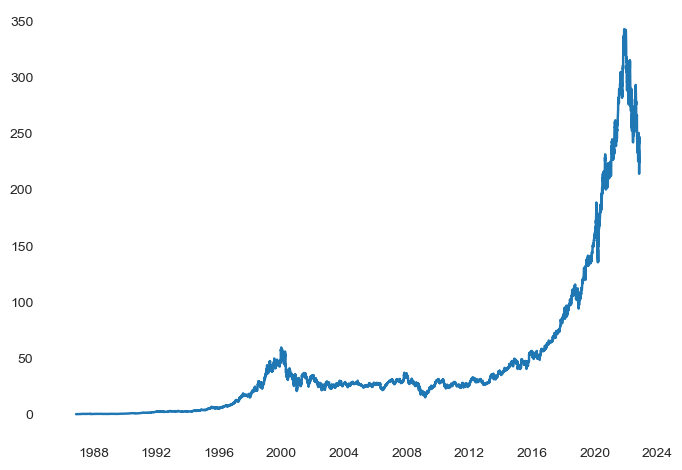

In [120]:
plt.plot(df.index, df["Close"])

In [121]:
def df_to_windowed_df(dataframe,first_date_str,last_date_str, n= 3):
    first_date= str_to_datetime(first_date_str)
    last_date= str_to_datetime(last_date_str)
    
    target_date = first_date
    
    dates = []
    X,Y = [],[]
    
    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
        
        if len(df_subset) != n+1:
            print(f'Error:windows of size {n} is too large for date {target_date}')
            return
        
        values = df_subset["Close"].to_numpy()
        x, y = values[:-1],values[-1]
        
        dates.append(target_date)
        X.append(x)
        Y.append(y)
        
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days = 7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split("T")[0]
        year_month_day = next_date_str.split("-")
        year,month, day = year_month_day
        next_date = datetime.datetime(day = int(day), month = int(month), year = int(year))
        
        if last_time:
            break
            
        target_date = next_date
        
        if target_date == last_date:
            last_time = True
    
    
    ret_df = pd.DataFrame({})
    ret_df["Target Date"] = dates
    
    X = np.array(X)
    
    for i in range(0,n):
        X[:,i]
        ret_df[f'Target-{n-i}']=X[:,i]
        
    ret_df["Target"] = Y
    
    return ret_df

In [122]:
windowed_df = df_to_windowed_df(df,'2021-11-20','2022-11-15', n= 3)

In [123]:
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-11-20,339.510010,339.119995,341.269989,343.109985
1,2021-11-23,341.269989,343.109985,339.829987,337.679993
2,2021-11-24,343.109985,339.829987,337.679993,337.910004
3,2021-11-26,339.829987,337.679993,337.910004,329.679993
4,2021-11-29,337.679993,337.910004,329.679993,336.630005
...,...,...,...,...,...
243,2022-11-09,221.389999,227.869995,228.869995,224.509995
244,2022-11-10,227.869995,228.869995,224.509995,242.979996
245,2022-11-11,228.869995,224.509995,242.979996,247.110001
246,2022-11-14,224.509995,242.979996,247.110001,241.550003


In [124]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_np = windowed_dataframe.to_numpy()
    
    dates = df_np[:,0]
    
    middle_mitrix = df_np[:,1:-1]
    
    X = middle_mitrix.reshape((len(dates),middle_mitrix.shape[1],1)) # number 1 at the end show than only one variable as close we consider
    
    Y = df_np[:,-1]
    
    return dates, X.astype(np.float32), Y.astype(np.float32)
    

In [125]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((248,), (248, 3, 1), (248,))

# Spliting data

Text(0, 0.5, 'Close')

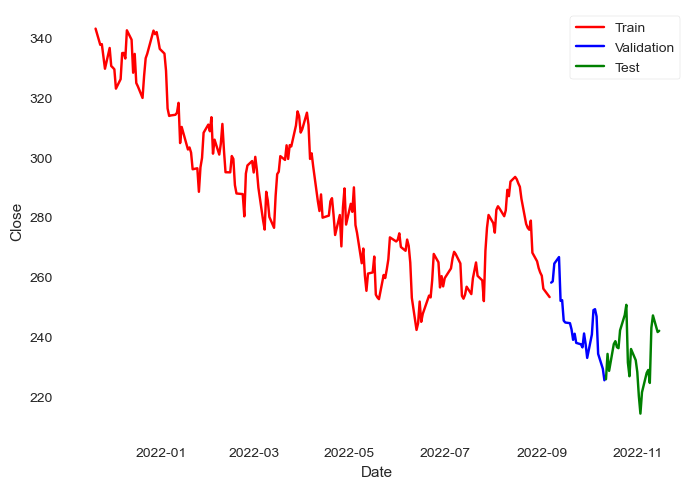

In [126]:
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val,X_val, y_val = dates[q_80:q_90],X[q_80:q_90],y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:],X[q_90:],y[q_90:]

plt.plot(dates_train,y_train, color = "red")
plt.plot(dates_val,y_val, color = "blue")
plt.plot(dates_test, y_test, color = "green")
plt.legend(["Train","Validation","Test"])
plt.xlabel("Date")
plt.ylabel("Close")

# Make the model

In [127]:
model = Sequential([layers.Input((3,1)),
                  layers.LSTM(64),
                  layers.Dense(32, activation = "relu"),
                  layers.Dense(32, activation = "relu"),
                  layers.Dense(1)])

model.compile(loss = "mse", 
              optimizer = Adam(learning_rate= 0.001),
             metrics = ["mean_absolute_error"])


# Fit the Model

In [128]:
model.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 87ms/step - loss: 84016.0391 - mean_absolute_error: 288.7021 - val_loss: 59317.0234 - val_mean_absolute_error: 243.3414
Epoch 2/100
7/7 [==============================] - 0s 12ms/step - loss: 83735.5703 - mean_absolute_error: 288.2162 - val_loss: 59084.0664 - val_mean_absolute_error: 242.8622
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 83436.1094 - mean_absolute_error: 287.6964 - val_loss: 58772.6289 - val_mean_absolute_error: 242.2202
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 83025.6562 - mean_absolute_error: 286.9808 - val_loss: 58377.5391 - val_mean_absolute_error: 241.4032
Epoch 5/100
7/7 [==============================] - 0s 14ms/step - loss: 82514.1172 - mean_absolute_error: 286.0872 - val_loss: 57874.2539 - val_mean_absolute_error: 240.3587
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 81868.2188 - mean_absolute_error: 284.9579 - val_loss: 572

7/7 [==============================] - 0s 12ms/step - loss: 667.5612 - mean_absolute_error: 21.5472 - val_loss: 2177.2095 - val_mean_absolute_error: 45.5554
Epoch 49/100
7/7 [==============================] - 0s 11ms/step - loss: 667.5593 - mean_absolute_error: 21.5394 - val_loss: 2124.4573 - val_mean_absolute_error: 44.9956
Epoch 50/100
7/7 [==============================] - 0s 13ms/step - loss: 629.0139 - mean_absolute_error: 20.4309 - val_loss: 2218.5271 - val_mean_absolute_error: 46.0115
Epoch 51/100
7/7 [==============================] - 0s 11ms/step - loss: 667.7682 - mean_absolute_error: 21.6014 - val_loss: 2251.1057 - val_mean_absolute_error: 46.3596
Epoch 52/100
7/7 [==============================] - 0s 12ms/step - loss: 668.8163 - mean_absolute_error: 21.6242 - val_loss: 2243.4468 - val_mean_absolute_error: 46.2768
Epoch 53/100
7/7 [==============================] - 0s 11ms/step - loss: 668.3983 - mean_absolute_error: 21.6055 - val_loss: 2224.5212 - val_mean_absolute_error: 4

7/7 [==============================] - 0s 12ms/step - loss: 125.7881 - mean_absolute_error: 8.8706 - val_loss: 166.3132 - val_mean_absolute_error: 11.3619
Epoch 97/100
7/7 [==============================] - 0s 14ms/step - loss: 119.9454 - mean_absolute_error: 8.8494 - val_loss: 81.5696 - val_mean_absolute_error: 7.7309
Epoch 98/100
7/7 [==============================] - 0s 12ms/step - loss: 124.9672 - mean_absolute_error: 8.7280 - val_loss: 132.7424 - val_mean_absolute_error: 9.9466
Epoch 99/100
7/7 [==============================] - 0s 12ms/step - loss: 115.4257 - mean_absolute_error: 8.5239 - val_loss: 137.2487 - val_mean_absolute_error: 10.1443
Epoch 100/100
7/7 [==============================] - 0s 10ms/step - loss: 91.5627 - mean_absolute_error: 7.4578 - val_loss: 179.3776 - val_mean_absolute_error: 12.0211


7/7 [==============================] - 0s 4ms/step


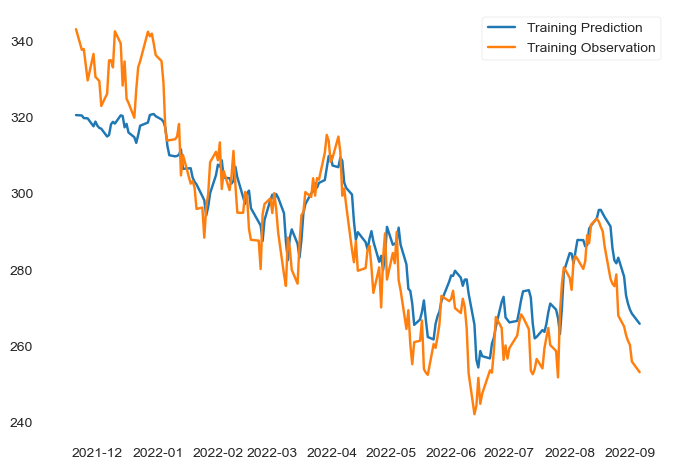

In [129]:
train_prediction = model.predict(X_train).flatten()

plt.plot(dates_train,train_prediction)
plt.plot(dates_train, y_train)
plt.legend(["Training Prediction","Training Observation"])

1/1 [==============================] - 0s 24ms/step


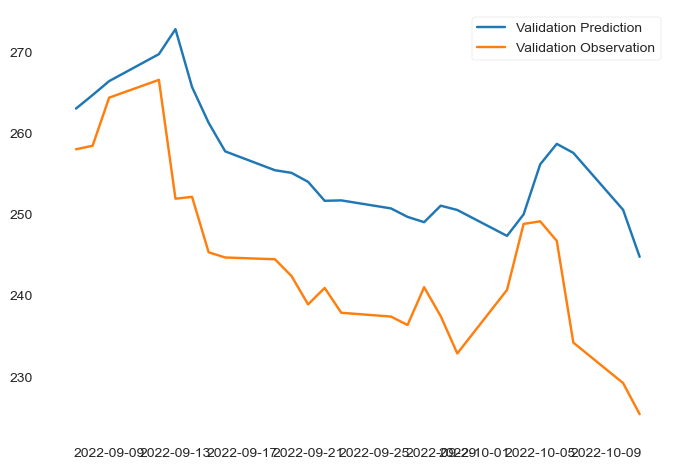

In [130]:
val_prediction = model.predict(X_val).flatten()

plt.plot(dates_val,val_prediction)
plt.plot(dates_val, y_val)
plt.legend(["Validation Prediction","Validation Observation"])

1/1 [==============================] - 0s 24ms/step


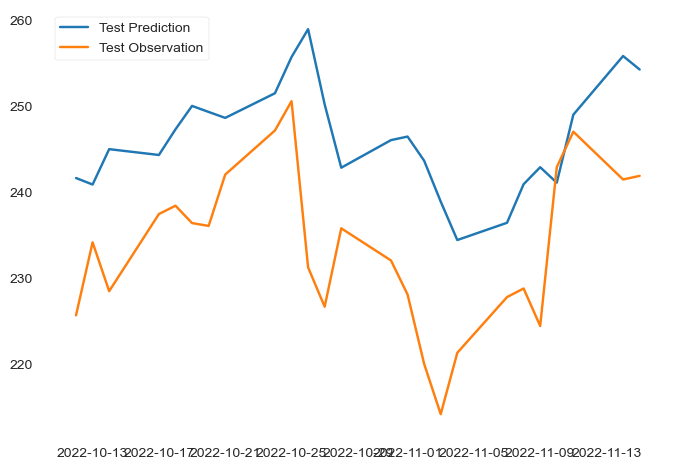

In [131]:
test_prediction = model.predict(X_test).flatten()

plt.plot(dates_test,test_prediction)
plt.plot(dates_test, y_test)
plt.legend(["Test Prediction","Test Observation"])

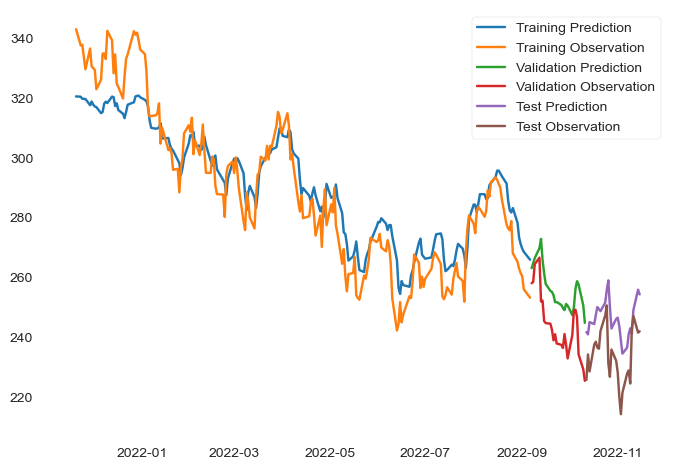

In [132]:
plt.plot(dates_train,train_prediction)
plt.plot(dates_train, y_train)
plt.plot(dates_val,val_prediction)
plt.plot(dates_val, y_val)
plt.plot(dates_test,test_prediction)
plt.plot(dates_test, y_test)
plt.legend(["Training Prediction","Training Observation",
           "Validation Prediction","Validation Observation",
           "Test Prediction","Test Observation"])


In [133]:
recursive_predictions = []
recursive_dates= np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
    last_window = deepcopy(X_train[-1])
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    last_window[-1] = next_prediction

1/1 [==============================] - 0s 25ms/step


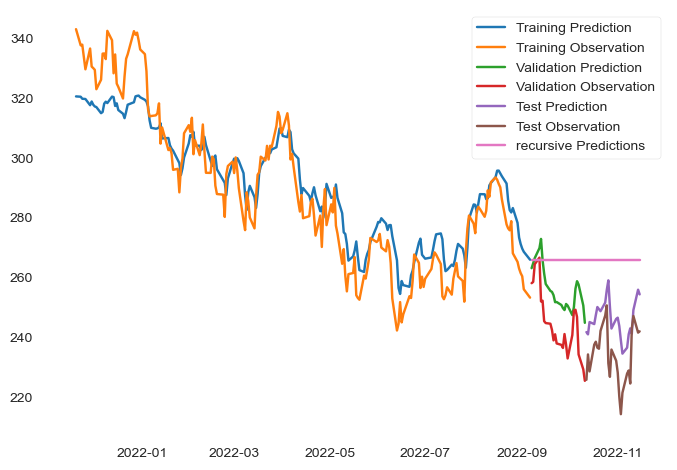

In [134]:
plt.plot(dates_train,train_prediction)
plt.plot(dates_train, y_train)
plt.plot(dates_val,val_prediction)
plt.plot(dates_val, y_val)
plt.plot(dates_test,test_prediction)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates,recursive_predictions)
plt.legend(["Training Prediction","Training Observation",
           "Validation Prediction","Validation Observation",
           "Test Prediction","Test Observation",
           "recursive Predictions"])